TODO: 
1. Use data from Bookshop.xlsx and test/train
2. Combine data regarding books into one table
3. Clean and encode accordingly data other than int
4. Use ML models to generate prices (optional: use different dataset to teach models)
5. Use historical data to predict future sales using eg. ARMA

Questions:
1. How to split data? Is it better to split it manually or use split function from sklearn? Check both outcomes and make notes

In [2]:
import os

# math
import numpy as np
import pandas as pd
import re
import time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.metrics import accuracy_score, explained_variance_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

In [3]:
# upload data
test_data = pd.read_excel('test.xlsx')
train_data = pd.read_excel('train.xlsx')

# replace characters
train_data.columns = train_data.columns.str.upper().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.upper().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

train_data.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_27476/1595102578.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_data.columns = train_data.columns.str.upper().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
C:\Users\Admin\AppData\Local\Temp/ipykernel_27476/1595102578.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_data.columns = train_data.columns.str.upper().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
C:\Users\Admin\AppData\Local\Temp/ipykernel_27476/1595102578.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular exp

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,SYNOPSIS,GENRE,BOOKCATEGORY,PRICE
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TITLE         6237 non-null   object 
 1   AUTHOR        6237 non-null   object 
 2   EDITION       6237 non-null   object 
 3   REVIEWS       6237 non-null   object 
 4   RATINGS       6237 non-null   object 
 5   SYNOPSIS      6237 non-null   object 
 6   GENRE         6237 non-null   object 
 7   BOOKCATEGORY  6237 non-null   object 
 8   PRICE         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [5]:
train_data.describe(include='all').head(2)

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,SYNOPSIS,GENRE,BOOKCATEGORY,PRICE
count,6237,6237,6237,6237,6237,6237,6237,6237,6237.0
unique,5568,3679,3370,36,342,5549,345,11,NaN


In [6]:
train_data.columns

Index(['TITLE', 'AUTHOR', 'EDITION', 'REVIEWS', 'RATINGS', 'SYNOPSIS', 'GENRE',
       'BOOKCATEGORY', 'PRICE'],
      dtype='object')

In [7]:
train_data.nunique()

TITLE           5568
AUTHOR          3679
EDITION         3370
REVIEWS           36
RATINGS          342
SYNOPSIS        5549
GENRE            345
BOOKCATEGORY      11
PRICE           1614
dtype: int64

In [8]:
test_data.nunique()

TITLE           1521
AUTHOR          1224
EDITION         1259
REVIEWS           30
RATINGS          163
SYNOPSIS        1519
GENRE            225
BOOKCATEGORY      11
dtype: int64

In [9]:
train_data.isnull().sum()

TITLE           0
AUTHOR          0
EDITION         0
REVIEWS         0
RATINGS         0
SYNOPSIS        0
GENRE           0
BOOKCATEGORY    0
PRICE           0
dtype: int64

In [10]:
test_data.isnull().sum()

TITLE           0
AUTHOR          0
EDITION         0
REVIEWS         0
RATINGS         0
SYNOPSIS        0
GENRE           0
BOOKCATEGORY    0
dtype: int64

In [11]:
# Delete synopsisi since it will not be used and can confuse outcome
train_data = train_data.drop(['SYNOPSIS'], axis=1)
test_data = test_data.drop(['SYNOPSIS'], axis=1)

In [12]:
train_data['TYPE'] = 'train'
test_data['TYPE'] = 'test'

data = pd.concat([train_data, test_data])
data.tail()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE
1555,100 Things Every Designer Needs to Know About ...,Susan Weinschenk,"Paperback,– 14 Apr 2011",5.0 out of 5 stars,4 customer reviews,Design,"Computing, Internet & Digital Media",NaN,test
1556,"Modern Letter Writing Course: Personal, Busine...",ARUN SAGAR,"Paperback,– 8 May 2013",3.6 out of 5 stars,13 customer reviews,Children's Reference (Books),"Biographies, Diaries & True Accounts",NaN,test
1557,The Kite Runner Graphic Novel,Khaled Hosseini,"Paperback,– 6 Sep 2011",4.0 out of 5 stars,5 customer reviews,Humour (Books),Humour,NaN,test
1558,Panzer Leader (Penguin World War II Collection),Heinz Guderian,"Paperback,– 22 Sep 2009",3.5 out of 5 stars,3 customer reviews,United States History,"Biographies, Diaries & True Accounts",NaN,test
1559,Complete Spanish Step-by-Step,Barbara Bregstein,"Paperback,– 16 Sep 2016",4.5 out of 5 stars,2 customer reviews,Dictionaries,"Language, Linguistics & Writing",NaN,test


### Editing and encoding data

In [13]:
# PUBLICATION & YEAR
data['YEAR'] = data['EDITION'].str[-4:]
# ed_year = [int(m_y[i][1].strip()) if m_y[i][1].isdigit() else 0 for i in range(len(m_y))]

# Random publication year for some books
data['YEAR'] = data['YEAR'].apply(lambda x: re.sub("[^0-9]", 'NA', x))
data['YEAR'] = data['YEAR'].apply(lambda x: x.replace('NA', '0'))
data['YEAR'] = data['YEAR'].astype(np.int16)

data['AGE'] = 2022 - data['YEAR']

data.loc[(data['YEAR'] == 0), 'YEAR'] = np.NaN
avg_age = data['AGE'].mean()
data.loc[(data['YEAR'].isnull()), 'AGE'] = avg_age

data.head()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,International Relations,Humour,299.00,train,1982.0,40.0
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0


In [14]:
# REVIEWS
data['REVIEWS'] = data['REVIEWS'].apply(lambda x: x.split(' ')[0])
data['REVIEWS'] = data['REVIEWS'].astype('float')
data.head()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8 customer reviews,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14 customer reviews,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6 customer reviews,International Relations,Humour,299.00,train,1982.0,40.0
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13 customer reviews,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1 customer review,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0


In [15]:
# RATINGS
data['RATINGS'] = data['RATINGS'].apply(lambda x: x.split(' ')[0])
data['RATINGS'] = data['RATINGS'].apply(lambda x: int(x.replace(',', '')))
data.head()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6,International Relations,Humour,299.00,train,1982.0,40.0
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0


In [16]:
# TITLE
data['TITLE'] = data['TITLE'].str.upper()
data.head()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE
0,THE PRISONER'S GOLD (THE HUNTERS 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0
1,GURU DUTT: A TRAGEDY IN THREE ACTS,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0
2,LEVIATHAN (PENGUIN CLASSICS),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6,International Relations,Humour,299.00,train,1982.0,40.0
3,A POCKET FULL OF RYE (MISS MARPLE),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0
4,LIFE 70 YEARS OF EXTRAORDINARY PHOTOGRAPHY,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0


In [17]:
# EDITION
data['EDITION'] = data['EDITION'].apply(lambda x: x.split(",")[0].strip().upper())
data.head()

,TITLE,AUTHOR,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE
0,THE PRISONER'S GOLD (THE HUNTERS 3),Chris Kuzneski,PAPERBACK,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0
1,GURU DUTT: A TRAGEDY IN THREE ACTS,Arun Khopkar,PAPERBACK,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0
2,LEVIATHAN (PENGUIN CLASSICS),Thomas Hobbes,PAPERBACK,4.8,6,International Relations,Humour,299.00,train,1982.0,40.0
3,A POCKET FULL OF RYE (MISS MARPLE),Agatha Christie,PAPERBACK,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0
4,LIFE 70 YEARS OF EXTRAORDINARY PHOTOGRAPHY,Editors of Life,HARDCOVER,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0


In [18]:
# AUTHOR
data['AUTHOR'] = data['AUTHOR'].str.upper()
max_aut = max([len(x.split(",")) for x in list(data['AUTHOR'])])

authors = list(data['AUTHOR'])

A1 = []
A2 = []
A3 = []
A4 = []
A5 = []
A6 = []
A7 = []

for i in authors:
  
  try :
    A1.append(i.split(',')[0].strip().upper())
  except :
    A1.append('NONE')
    
  try :
    A2.append(i.split(',')[1].strip().upper())
  except :
    A2.append('NONE')
      
  try :
    A3.append(i.split(',')[2].strip().upper())
  except :
    A3.append('NONE')
      
  try :
    A4.append(i.split(',')[3].strip().upper())
  except :
    A4.append('NONE')
      
  try :
    A5.append(i.split(',')[4].strip().upper())
  except :
    A5.append('NONE')
    
  try :
    A6.append(i.split(',')[5].strip().upper())
  except :
    A6.append('NONE')
    
  try :
    A7.append(i.split(',')[6].strip().upper())
  except :
    A7.append('NONE')

data["AUTHOR1"] = A1
data["AUTHOR2"] = A2
data["AUTHOR3"] = A3
data["AUTHOR4"] = A4
data["AUTHOR5"] = A5
data["AUTHOR6"] = A6
data["AUTHOR7"] = A7
data = data.drop(['AUTHOR'], axis=1)

data.head()

,TITLE,EDITION,REVIEWS,RATINGS,GENRE,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7
0,THE PRISONER'S GOLD (THE HUNTERS 3),PAPERBACK,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016.0,6.0,CHRIS KUZNESKI,NONE,NONE,NONE,NONE,NONE,NONE
1,GURU DUTT: A TRAGEDY IN THREE ACTS,PAPERBACK,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0,ARUN KHOPKAR,NONE,NONE,NONE,NONE,NONE,NONE
2,LEVIATHAN (PENGUIN CLASSICS),PAPERBACK,4.8,6,International Relations,Humour,299.00,train,1982.0,40.0,THOMAS HOBBES,NONE,NONE,NONE,NONE,NONE,NONE
3,A POCKET FULL OF RYE (MISS MARPLE),PAPERBACK,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017.0,5.0,AGATHA CHRISTIE,NONE,NONE,NONE,NONE,NONE,NONE
4,LIFE 70 YEARS OF EXTRAORDINARY PHOTOGRAPHY,HARDCOVER,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006.0,16.0,EDITORS OF LIFE,NONE,NONE,NONE,NONE,NONE,NONE


In [19]:
# GENRE
max_gen = max([len(x.split(",")) for x in list(data['GENRE'])])
max_gen

genres = list(data['GENRE'])

G1 = []
G2 = []

for i in genres:

    try :
        G1.append(i.split(',')[0].strip().upper())
        
    except :
        G1.append('NONE')
        
    try :
        G2.append(i.split(',')[1].strip().upper())
    except :
        G2.append('NONE')

data['GENRE1'] = G1
data['GENRE2'] = G2
data = data.drop(['GENRE'], axis=1)

data.head()

,TITLE,EDITION,REVIEWS,RATINGS,BOOKCATEGORY,PRICE,TYPE,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2
0,THE PRISONER'S GOLD (THE HUNTERS 3),PAPERBACK,4.0,8,Action & Adventure,220.00,train,2016.0,6.0,CHRIS KUZNESKI,NONE,NONE,NONE,NONE,NONE,NONE,ACTION & ADVENTURE (BOOKS),NONE
1,GURU DUTT: A TRAGEDY IN THREE ACTS,PAPERBACK,3.9,14,"Biographies, Diaries & True Accounts",202.93,train,2012.0,10.0,ARUN KHOPKAR,NONE,NONE,NONE,NONE,NONE,NONE,CINEMA & BROADCAST (BOOKS),NONE
2,LEVIATHAN (PENGUIN CLASSICS),PAPERBACK,4.8,6,Humour,299.00,train,1982.0,40.0,THOMAS HOBBES,NONE,NONE,NONE,NONE,NONE,NONE,INTERNATIONAL RELATIONS,NONE
3,A POCKET FULL OF RYE (MISS MARPLE),PAPERBACK,4.1,13,"Crime, Thriller & Mystery",180.00,train,2017.0,5.0,AGATHA CHRISTIE,NONE,NONE,NONE,NONE,NONE,NONE,CONTEMPORARY FICTION (BOOKS),NONE
4,LIFE 70 YEARS OF EXTRAORDINARY PHOTOGRAPHY,HARDCOVER,5.0,1,"Arts, Film & Photography",965.62,train,2006.0,16.0,EDITORS OF LIFE,NONE,NONE,NONE,NONE,NONE,NONE,PHOTOGRAPHY TEXTBOOKS,NONE


In [20]:
# CATEGORY
max_cat = max([len(x.split(",")) for x in list(data['BOOKCATEGORY'])])
max_cat

category = list(data['BOOKCATEGORY'])

C1 = []
C2 = []

for i in category:

    try :
        C1.append(i.split(',')[0].strip().upper())
        
    except :
        C1.append('NONE')
        
    try :
        C2.append(i.split(',')[1].strip().upper())
    except :
        C2.append('NONE')

data['CATEGORY1'] = C1
data['CATEGORY2'] = C2
data = data.drop(['BOOKCATEGORY'], axis=1)

data.tail()

,TITLE,EDITION,REVIEWS,RATINGS,PRICE,TYPE,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
1555,100 THINGS EVERY DESIGNER NEEDS TO KNOW ABOUT ...,PAPERBACK,5.0,4,NaN,test,2011.0,11.0,SUSAN WEINSCHENK,NONE,NONE,NONE,NONE,NONE,NONE,DESIGN,NONE,COMPUTING,INTERNET & DIGITAL MEDIA
1556,"MODERN LETTER WRITING COURSE: PERSONAL, BUSINE...",PAPERBACK,3.6,13,NaN,test,2013.0,9.0,ARUN SAGAR,NONE,NONE,NONE,NONE,NONE,NONE,CHILDREN'S REFERENCE (BOOKS),NONE,BIOGRAPHIES,DIARIES & TRUE ACCOUNTS
1557,THE KITE RUNNER GRAPHIC NOVEL,PAPERBACK,4.0,5,NaN,test,2011.0,11.0,KHALED HOSSEINI,NONE,NONE,NONE,NONE,NONE,NONE,HUMOUR (BOOKS),NONE,HUMOUR,NONE
1558,PANZER LEADER (PENGUIN WORLD WAR II COLLECTION),PAPERBACK,3.5,3,NaN,test,2009.0,13.0,HEINZ GUDERIAN,NONE,NONE,NONE,NONE,NONE,NONE,UNITED STATES HISTORY,NONE,BIOGRAPHIES,DIARIES & TRUE ACCOUNTS
1559,COMPLETE SPANISH STEP-BY-STEP,PAPERBACK,4.5,2,NaN,test,2016.0,6.0,BARBARA BREGSTEIN,NONE,NONE,NONE,NONE,NONE,NONE,DICTIONARIES,NONE,LANGUAGE,LINGUISTICS & WRITING


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7797 entries, 0 to 1559
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TITLE      7797 non-null   object 
 1   EDITION    7797 non-null   object 
 2   REVIEWS    7797 non-null   float64
 3   RATINGS    7797 non-null   int64  
 4   PRICE      6237 non-null   float64
 5   TYPE       7797 non-null   object 
 6   YEAR       7767 non-null   float64
 7   AGE        7797 non-null   float64
 8   AUTHOR1    7797 non-null   object 
 9   AUTHOR2    7797 non-null   object 
 10  AUTHOR3    7797 non-null   object 
 11  AUTHOR4    7797 non-null   object 
 12  AUTHOR5    7797 non-null   object 
 13  AUTHOR6    7797 non-null   object 
 14  AUTHOR7    7797 non-null   object 
 15  GENRE1     7797 non-null   object 
 16  GENRE2     7797 non-null   object 
 17  CATEGORY1  7797 non-null   object 
 18  CATEGORY2  7797 non-null   object 
dtypes: float64(4), int64(1), object(14)
memory usage

# APPROACH 1: spliting train and test datasets by hand

In [22]:
# SPLIT DATA INTO TWO SETS TRAIN AND TEST
train = data[data["TYPE"] == 'train']
train = train.drop(['TYPE'], axis=1)
test = data[data["TYPE"] == 'test']
test = test.drop(['TYPE'], axis=1)
train.head()

,TITLE,EDITION,REVIEWS,RATINGS,PRICE,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
0,THE PRISONER'S GOLD (THE HUNTERS 3),PAPERBACK,4.0,8,220.00,2016.0,6.0,CHRIS KUZNESKI,NONE,NONE,NONE,NONE,NONE,NONE,ACTION & ADVENTURE (BOOKS),NONE,ACTION & ADVENTURE,NONE
1,GURU DUTT: A TRAGEDY IN THREE ACTS,PAPERBACK,3.9,14,202.93,2012.0,10.0,ARUN KHOPKAR,NONE,NONE,NONE,NONE,NONE,NONE,CINEMA & BROADCAST (BOOKS),NONE,BIOGRAPHIES,DIARIES & TRUE ACCOUNTS
2,LEVIATHAN (PENGUIN CLASSICS),PAPERBACK,4.8,6,299.00,1982.0,40.0,THOMAS HOBBES,NONE,NONE,NONE,NONE,NONE,NONE,INTERNATIONAL RELATIONS,NONE,HUMOUR,NONE
3,A POCKET FULL OF RYE (MISS MARPLE),PAPERBACK,4.1,13,180.00,2017.0,5.0,AGATHA CHRISTIE,NONE,NONE,NONE,NONE,NONE,NONE,CONTEMPORARY FICTION (BOOKS),NONE,CRIME,THRILLER & MYSTERY
4,LIFE 70 YEARS OF EXTRAORDINARY PHOTOGRAPHY,HARDCOVER,5.0,1,965.62,2006.0,16.0,EDITORS OF LIFE,NONE,NONE,NONE,NONE,NONE,NONE,PHOTOGRAPHY TEXTBOOKS,NONE,ARTS,FILM & PHOTOGRAPHY


In [23]:
X_train = train.drop(['PRICE'],axis = 1)
y_train = train['PRICE'] #.values
X_test = test.drop(["PRICE"], axis=1)
X_train.describe(include = 'all')

,TITLE,EDITION,REVIEWS,RATINGS,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
count,6237,6237,6237.000000,6237.000000,6216.000000,6237.000000,6237,6237,6237,6237,6237,6237,6237,6237,6237,6237,6237
unique,5564,19,NaN,NaN,NaN,NaN,3633,264,73,21,5,1,1,345,27,11,6
top,A GAME OF THRONES (A SONG OF ICE AND FIRE),PAPERBACK,NaN,NaN,NaN,NaN,AGATHA CHRISTIE,NONE,NONE,NONE,NONE,NONE,NONE,ACTION & ADVENTURE (BOOKS),NONE,ACTION & ADVENTURE,NONE
freq,4,5193,NaN,NaN,NaN,NaN,69,5929,6159,6214,6233,6237,6237,947,5594,818,3297
mean,NaN,NaN,4.293202,35.984287,2011.875965,10.150040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.662501,149.995031,7.921572,7.920871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000,1900.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,2.000000,2010.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.400000,7.000000,2014.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.800000,22.000000,2017.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# # A method for Finding Unique items for all columns
# def unique_items(list1, list2):
#   a = list1
#   b = list2
#   a.extend(b)
#   return list(set(a))  

In [25]:
# le_Title = LabelEncoder()
# all_titles = unique_items(list(X_train.Title),list(X_test.Title))
# le_Title.fit(all_titles)

# le_Edition_Type = LabelEncoder()
# all_etypes = unique_items(list(X_train.Edition_Type),list(X_test.Edition_Type))
# le_Edition_Type.fit(all_etypes)


# le_Edition_Month = LabelEncoder()
# all_em = unique_items(list(X_train.Edition_Month),list(X_test.Edition_Month))
# le_Edition_Month.fit(all_em)

# le_Author = LabelEncoder()
# all_Authors = list(set(all_authors))
# le_Author.fit(all_Authors)

# le_Genre = LabelEncoder()
# all_Genres = list(set(all_genres))
# le_Genre.fit(all_Genres)

# le_Category = LabelEncoder()
# all_Categories = list(set(all_categories))
# le_Category.fit(all_Categories)

In [26]:
encode = LabelEncoder()

X_train['TITLE'] = encode.fit_transform(list(X_train['TITLE']))
X_train['EDITION'] = encode.fit_transform(list(X_train['EDITION']))

X_train['AUTHOR1'] = encode.fit_transform(list(X_train['AUTHOR1']))
X_train['AUTHOR2'] = encode.fit_transform(list(X_train['AUTHOR2']))
X_train['AUTHOR3'] = encode.fit_transform(list(X_train['AUTHOR3']))
X_train['AUTHOR4'] = encode.fit_transform(list(X_train['AUTHOR4']))
X_train['AUTHOR5'] = encode.fit_transform(list(X_train['AUTHOR5']))
X_train['AUTHOR6'] = encode.fit_transform(list(X_train['AUTHOR6']))
X_train['AUTHOR7'] = encode.fit_transform(list(X_train['AUTHOR7']))

X_train['GENRE1'] = encode.fit_transform(list(X_train['GENRE1']))
X_train['GENRE2'] = encode.fit_transform(list(X_train['GENRE2']))
X_train['CATEGORY1'] = encode.fit_transform(list(X_train['CATEGORY1']))
X_train['CATEGORY2'] = encode.fit_transform(list(X_train['CATEGORY2']))


X_test['TITLE'] = encode.fit_transform(list(X_test['TITLE']))
X_test['EDITION'] = encode.fit_transform(list(X_test['EDITION']))

X_test['AUTHOR1'] = encode.fit_transform(list(X_test['AUTHOR1']))
X_test['AUTHOR2'] = encode.fit_transform(list(X_test['AUTHOR2']))
X_test['AUTHOR3'] = encode.fit_transform(list(X_test['AUTHOR3']))
X_test['AUTHOR4'] = encode.fit_transform(list(X_test['AUTHOR4']))
X_test['AUTHOR5'] = encode.fit_transform(list(X_test['AUTHOR5']))
X_test['AUTHOR6'] = encode.fit_transform(list(X_test['AUTHOR6']))
X_test['AUTHOR7'] = encode.fit_transform(list(X_test['AUTHOR7']))

X_test['GENRE1'] = encode.fit_transform(list(X_test['GENRE1']))
X_test['GENRE2'] = encode.fit_transform(list(X_test['GENRE2']))
X_test['CATEGORY1'] = encode.fit_transform(list(X_test['CATEGORY1']))
X_test['CATEGORY2'] = encode.fit_transform(list(X_test['CATEGORY2']))

In [27]:
X_train.head()

,TITLE,EDITION,REVIEWS,RATINGS,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
0,4763,12,4.0,8,2016.0,6.0,606,159,44,13,4,0,0,0,17,0,4
1,1721,12,3.9,14,2012.0,10.0,299,159,44,13,4,0,0,73,17,2,0
2,2448,12,4.8,6,1982.0,40.0,3351,159,44,13,4,0,0,192,17,6,4
3,155,12,4.1,13,2017.0,5.0,55,159,44,13,4,0,0,91,17,5,5
4,2450,7,5.0,1,2006.0,16.0,938,159,44,13,4,0,0,253,17,1,1


In [28]:
X_test.head()

,TITLE,EDITION,REVIEWS,RATINGS,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
0,1143,5,4.4,960,1986.0,36.0,1060,50,14,4,2,1,1,189,14,5,5
1,663,6,5.0,1,2018.0,4.0,350,50,14,4,2,1,1,163,14,4,2
2,182,6,5.0,4,2011.0,11.0,234,50,14,4,2,1,1,185,14,9,4
3,1395,6,4.1,11,2016.0,6.0,43,50,14,4,2,1,1,174,14,4,2
4,863,6,4.4,9,2011.0,11.0,924,50,14,4,2,1,1,143,14,7,3


In [29]:
y_train.isna().sum()

0

In [30]:
# SCALE
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# reshaping
y_train = y_train.values.reshape((len(y_train), 1))
y_train = sc.fit_transform(y_train)
y_train = y_train.ravel()

# X = sc.fit_transform(X)

# y = y.values.reshape((len(y), 1))
# y = sc.fit_transform(y)
# y = y.ravel()

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(6237, 17)
(6237,)
(1560, 17)


In [32]:
X_train

array([[ 1.22873101,  0.39032076, -0.44260333, ..., -0.03116115,
        -1.46017334,  0.51996545],
       [-0.65705598,  0.39032076, -0.59355848, ..., -0.03116115,
        -0.82907247, -2.16799517],
       [-0.20637644,  0.39032076,  0.76503793, ..., -0.03116115,
         0.43312927,  0.51996545],
       ...,
       [ 0.91753276,  0.39032076, -0.74451364, ..., -0.03116115,
         1.37978058,  0.51996545],
       [-0.7574825 ,  0.39032076, -1.19737911, ..., -0.03116115,
        -1.46017334,  0.51996545],
       [ 0.95534769,  0.39032076, -0.59355848, ..., -0.03116115,
        -1.46017334,  0.51996545]])

In [33]:
X_test

array([[ 0.87045897, -0.46218192,  0.14022265, ..., -0.02508461,
         0.10266644,  1.21334639],
       [-0.2209306 ,  0.44020081,  1.03918433, ..., -0.02508461,
        -0.20533288, -0.86896425],
       [-1.31459389,  0.44020081,  1.03918433, ..., -0.02508461,
         1.33466373,  0.51924285],
       ...,
       [ 1.0500835 ,  0.44020081, -0.45908513, ..., -0.02508461,
         0.41066576,  0.51924285],
       [ 0.25200488,  0.44020081, -1.20821986, ..., -0.02508461,
        -0.82133153, -2.25717134],
       [-1.0985897 ,  0.44020081,  0.2900496 , ..., -0.02508461,
         0.71866509, -0.1748607 ]])

In [34]:
np.any(np.isnan(y_train))

False

In [35]:
np.all(np.isfinite(y_train))

True

### Model

In [36]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.3, random_state = 123)

# make plot with different test sizes to show which is more optimal

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(4365, 17)
(4365,)
(1872, 17)
(1872,)


Training score:  0.2830105948505969
Training score:  0.7795945612896643
Training score:  0.9367247552847102
Training score:  0.9832972645871773
Training score:  0.9913519140914633
Training score:  0.992162023101485


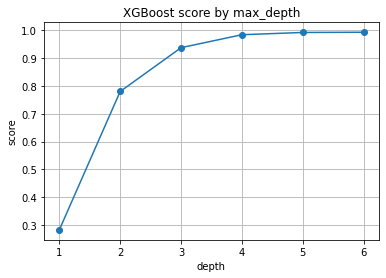

In [37]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# xgb=XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, n_estimators=100, booster = 'gbtree', n_jobs = -1,random_state = 1)
skorr = []

for i in range(1, 7):
    xgb=XGBRegressor(n_estimators=1000, max_depth=i)

    xgb.fit(train_x, train_y)

    y_ = xgb.predict(val_x)

    y_pred = sc.inverse_transform([y_])
    y_true = sc.inverse_transform([val_y])

    score_ = xgb.score(train_x, train_y)  
    print("Training score: ", score_)
    skorr.append(score_)

plt.plot(np.arange(1,7), skorr, '-o')
plt.title('XGBoost score by max_depth')
plt.grid()
plt.ylabel('score')
plt.xlabel('depth')
plt.show()

# scores = cross_val_score(xgb, train_x, train_y, cv=100)
# print("Mean cross-validation score: {0} with deviation {1}".format(scores.mean(), scores.std()))

In [38]:
# y_pred = y_pred.reshape(len(y_pred[0]),)
print(y_true.shape)
print(y_pred.shape)

(1, 1872)
(1, 1872)


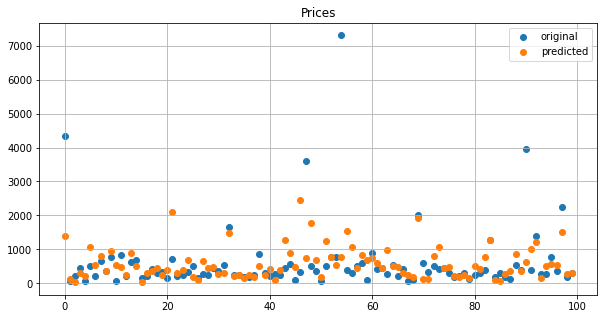

In [39]:
x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="original")
plt.scatter(x_ax, y_pred[0][:100], label="predicted")
plt.title("Prices")
plt.grid()
plt.legend()
plt.show()

In [40]:
xgb.fit(X_train, y_train)

score = xgb.score(X_train, y_train)  
print("Training score: ", score)

Y_ = xgb.predict(X_test)

y_pred_xgb = sc.inverse_transform([Y_])

solution = pd.DataFrame(y_pred_xgb[0], columns = ['PRICE'])

solution.head()


Training score:  0.9936712095117063


,PRICE
0,217.546785
1,866.564897
2,573.128247
3,837.598884
4,324.756958


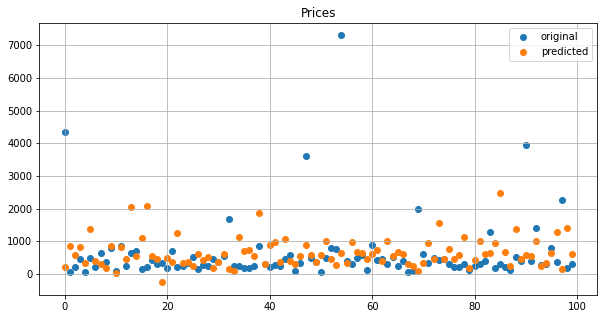

In [41]:
x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="original")
plt.scatter(x_ax, y_pred_xgb[0][:100], label="predicted")
plt.title("Prices")
plt.grid()
plt.legend()
plt.show()

In [42]:
np.any(np.isnan(X_train))

True

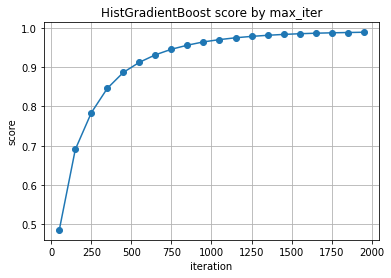

Training Score 0.9887665272834569


,PRICE
0,1802.734766
1,163.443379
2,607.710344
3,607.590530
4,147.928958


In [43]:
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingRegressor

skor = []

for i in range(50, 2050, 100):
    hist = HistGradientBoostingRegressor(loss='squared_error', quantile=None, learning_rate=0.1, max_iter=i, max_leaf_nodes=31, max_depth=None)
    # hist = GradientBoostingRegressor(random_state=0)
    hist.fit(train_x, train_y)

    skor.append(hist.score(train_x, train_y))

plt.plot(np.arange(50, 2050, 100), skor, '-o')
plt.title('HistGradientBoost score by max_iter')
plt.grid()
plt.ylabel('score')
plt.xlabel('iteration')
plt.show()

print("Training Score", hist.score(train_x, train_y))
# print("Test Score", clf.score(X_test, y_test))

Y_pred = hist.predict(val_x)
y_pred_hist = sc.inverse_transform([Y_pred])
solution_hist = pd.DataFrame(y_pred_hist[0], columns = ['PRICE'])
solution_hist.head()

In [44]:
# from sklearn.impute import SimpleImputer

# # handle nans
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(X_train)
# X_train = imp.transform(X_train)

# clf = DecisionTreeRegressor()

# clf.fit(X_train, y_train)

# y_pred_train = clf.predict(X_train)
# print(accuracy_score(y_train, y_pred_train))

# y_pred = clf.predict(X_test)
# y_pred = sc.inverse_transform([y_pred])

# solution_tree = pd.DataFrame(y_pred, columns = ['PRICE'])

# print("Train score:", clf.score(X_train, y_train))

# solution_tree.head()

# APPROACH 2: splitting data using split_train_test function

In [45]:
# data = data.dropna()
print(data.shape)

X = data.drop(["PRICE", "TYPE"], axis=1)
y = data["PRICE"] #.values

print(X.shape)
print(y.shape)

(7797, 19)
(7797, 17)
(7797,)


In [46]:
# FILL NANS
import random
y = [random.uniform(min(y), max(y)) if np.isnan(i) else i for i in y.values]

In [47]:
np.isnan(y)

array([False, False, False, ..., False, False, False])

In [48]:
encode = LabelEncoder()

X['TITLE'] = encode.fit_transform(list(X['TITLE']))
X['EDITION'] = encode.fit_transform(list(X['EDITION']))

X['AUTHOR1'] = encode.fit_transform(list(X['AUTHOR1']))
X['AUTHOR2'] = encode.fit_transform(list(X['AUTHOR2']))
X['AUTHOR3'] = encode.fit_transform(list(X['AUTHOR3']))
X['AUTHOR4'] = encode.fit_transform(list(X['AUTHOR4']))
X['AUTHOR5'] = encode.fit_transform(list(X['AUTHOR5']))
X['AUTHOR6'] = encode.fit_transform(list(X['AUTHOR6']))
X['AUTHOR7'] = encode.fit_transform(list(X['AUTHOR7']))

X['GENRE1'] = encode.fit_transform(list(X['GENRE1']))
X['GENRE2'] = encode.fit_transform(list(X['GENRE2']))
X['CATEGORY1'] = encode.fit_transform(list(X['CATEGORY1']))
X['CATEGORY2'] = encode.fit_transform(list(X['CATEGORY2']))

y = encode.fit_transform(list(y))
X['YEAR'] = encode.fit_transform(list(X['YEAR']))
X['AGE'] = encode.fit_transform(list(X['AGE']))

X.tail()

,TITLE,EDITION,REVIEWS,RATINGS,YEAR,AGE,AUTHOR1,AUTHOR2,AUTHOR3,AUTHOR4,AUTHOR5,AUTHOR6,AUTHOR7,GENRE1,GENRE2,CATEGORY1,CATEGORY2
1555,16,13,5.0,4,49,8,3870,196,55,17,6,1,1,103,17,4,2
1556,3316,13,3.6,13,51,6,361,196,55,17,6,1,1,71,17,2,0
1557,5481,13,4.0,5,49,8,2121,196,55,17,6,1,1,186,17,6,4
1558,3807,13,3.5,3,47,10,1487,196,55,17,6,1,1,347,17,2,0
1559,1136,13,4.5,2,54,3,431,196,55,17,6,1,1,109,17,7,3


In [49]:
print(X.shape)
print(y.shape)

(7797, 17)
(7797,)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

y_train = y_train.reshape(-1,1)
y_train = StandardScaler().fit_transform(y_train)

y_test = y_test.reshape(-1,1)
y_test = StandardScaler().fit_transform(y_test)

X_train


array([[ 0.95512184,  0.39394591,  0.15368615, ..., -0.03270731,
         0.1198637 ,  1.19772118],
       [-0.42963699,  0.39394591,  0.00254805, ..., -0.03270731,
        -0.82399806, -2.15853048],
       [-0.39718566,  0.39394591,  0.00254805, ..., -0.03270731,
        -0.19475689, -0.81602982],
       ...,
       [ 0.90796601,  0.39394591,  1.06051472, ..., -0.03270731,
        -1.13861864, -1.48728015],
       [-0.79674259,  0.39394591,  0.15368615, ..., -0.03270731,
        -1.13861864, -1.48728015],
       [-1.39100745,  0.39394591, -0.45086624, ..., -0.03270731,
         1.06372545,  0.52647085]])

In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5457, 17)
(5457, 1)
(2340, 17)
(2340, 1)


In [52]:
xgb=XGBRegressor(n_estimators=1000, max_depth=7)

xgb.fit(X_train, y_train)

y_ = xgb.predict(X_test)

y_pred = sc.inverse_transform([y_])
# y_true = sc.inverse_transform([y_test])
print(y_pred[0])
print(y_train)

score2 = xgb.score(X_train, y_train)  
print("Score for split function train:", score2)

score3 = xgb.score(X_test, y_test)  
print("Score for split function test:", score3)

[ 407.36317163  463.96780254  443.62746299 ...  307.7432223  -483.88657896
  583.04345914]
[[ 0.80245382]
 [-0.8099768 ]
 [-0.60647776]
 ...
 [ 0.35834709]
 [ 2.6842214 ]
 [ 0.03993095]]
Score for split function train: 0.9877469786604436
Score for split function test: -0.20439616525422322


In [53]:
hist = HistGradientBoostingRegressor(loss='squared_error', quantile=None, learning_rate=0.1, max_iter=1000, max_leaf_nodes=31, max_depth=None)
hist.fit(X_train, y_train)
y_train = y_train.ravel()

Y_pred = hist.predict(X_test)
y_pred_hist = sc.inverse_transform([Y_pred])

print("Training Score", hist.score(X_train, y_train))
print("Training Score", hist.score(X_test, y_test))
print("Training Score", cross_val_score(hist, X_train, y_train).mean())

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score 0.8901153891540167
Training Score -0.13630950801665298
Training Score -0.1928185501321754


In [54]:
# clf = DecisionTreeRegressor(random_state=0)

# clf.fit(X_train, y_train)

# y_pred_train = clf.predict(X_train)
# # print(accuracy_score(y_train, y_pred_train))

# y_pred = clf.predict(X_test)
# print(y_pred)

# print("Train score:", clf.score(X_train, y_train))
# print('Test score:', accuracy_score(X_test, y_test))
# # print(clf.score(X_test, y_test))

In [55]:
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# y_train = y_train.reshape(-1, 1)
# y_train = StandardScaler().fit_transform(y_train)
# # y_train = y_train.ravel()

# xgb = XGBRegressor( objective='reg:squarederror', max_depth=3, learning_rate=0.1, n_estimators=100, booster = 'gbtree', n_jobs = -1,random_state = 1)

# xgb.fit(X_train, y_train)

# y_pred_xgb = StandardScaler().inverse_transform(xgb.predict(X_test))
# y_true = StandardScaler().inverse_transform(y_test)

# error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
# score = 1 - error

# print("RMLSE Score = ", score)

# Vizualization

In [56]:
# plt.figure(figsize=(12,8))
# from sklearn import tree
# tree.plot_tree(clf.fit(X_train, y_train))

# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion matrix\n\n', cm)

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

https://www.kaggle.com/code/subhradeep88/house-price-predict-decision-tree-random-forest

approach 1: Use tree/linear regression to predict prices of products based on prices from previous years

approach 2: check accuracy of price classification for varius atributes fo products